In [6]:
graphics_toolkit("gnuplot"); % use if "plot" does not work

## Finite element method (FEM) in 1d

Solve the following 1d diffusion boundary value problem using linear finite elements. Compute the FEM solution $u_h$ for several different step sizes $h$ ($h$=L/N). For each $h$, calculate the approximations of $||u-u_h||_{2,0}$ and $||u-u_h||_{2,1}$. Visualize the dependence of these variables on the value of $h$.

In [7]:
%% boundary value problem:
%   -k*u''(x)=f     in (0,L)
%        u(0)=U0
%        u(1)=U1

global f k L U0 UL T
f=1;
k=1;
L=1;
U0=0;
UL=0;

Wrap the FEM solution into a function that takes N and returns $u_h$ and NODES.

In [8]:
function [u,NODES] = FEM(N)
    global f k L U0 UL T
    % N ... number of intervals of the equidistant discretization
    %% preparation
    NODES=linspace(0,L,N+1)'; % all points (matrix of size (N+1)*dim)
    n_NODES=length(NODES); % number of nodes of the discretization
    ELEMENTS=[1:n_NODES-1; 2:n_NODES]'; % matrix of INDICES of elements
    n_ELEMENTS=size(ELEMENTS,1); % number of elements (equals N in 1d)
    DBOUNDARY=[1, n_NODES]; % vector of indices of Dirichlet boundary nodes
    DVALUE=[U0, UL]; % Dirichlet values in this boundary nodes
    FREENODE=true(n_NODES,1); FREENODE(DBOUNDARY)=false; % vector of indices of nodes without D. b. c.
    LENGTHS=NODES(ELEMENTS(:,2))-NODES(ELEMENTS(:,1)); % vector of legths of all elements
    MATERIALS=k*ones(n_ELEMENTS,1); % vector of material values at each element
    F=f*ones(n_ELEMENTS,1); % vector of source function values at each element
    
    %% local matrix and rhs
    A_local=[1 -1; -1 1]; % local matrix 2x2
    b_local=[1 1]'/2; % local r. h. s. 2x1

    %% global matrix and rhs
    A=zeros(n_NODES);
    b=zeros(n_NODES,1);
    for i=1:n_ELEMENTS
        A(ELEMENTS(i,:),ELEMENTS(i,:))=A(ELEMENTS(i,:),ELEMENTS(i,:))+A_local*MATERIALS(i)/LENGTHS(i);
        b(ELEMENTS(i,:))=b(ELEMENTS(i,:))+b_local*F(i)*LENGTHS(i);
    end
    
    %% boundary conditions
    u=zeros(n_NODES,1);
    u(~FREENODE)=DVALUE;
    b=b-A*u;
    u(FREENODE)=A(FREENODE,FREENODE)\b(FREENODE);
end

Prepare the analytical solution $u(x)$.

In [9]:
u=@(x)-f/(2*k)*x.^2+f*L*x/(2*k)+(UL-U0)*x/L+U0; % analytical solution
u_diff=@(x)-f/(2*k)*2*x+f*L/(2*k)+(UL-U0)/L;

Visual comparison:

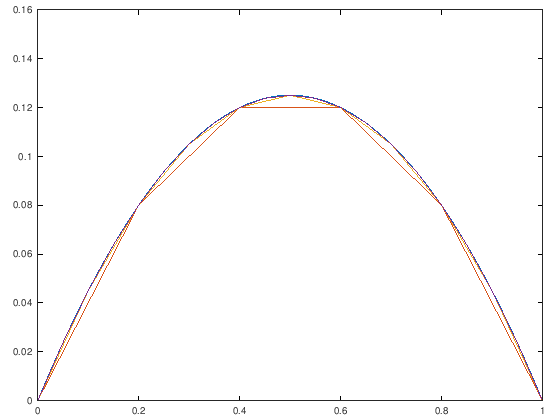

In [10]:
figure;
xx=linspace(0,L,100);
plot(xx,u(xx));
hold on;
N_vec = [5, 10, 20];
n = length(N_vec);
for i=1:n
    N = N_vec(i); % pocet intervalu diskretizace
    [uh,NODES] = FEM(N);
    plot(NODES,uh)
end

Prepare a function that calculate $||u-u_h||_{2,0}$ and $||u'-u'_h||_{2,0}$ (numerically).

In [11]:
function [L2error,L2error_d] = L2error(u,u_diff,uh,NODES)
    N = length(NODES)-1;
    %syms x
    %yy=vpa(subs(diff(u(x)),x,xx));
    L2error_pow = 0;
    L2error_d_pow = 0;
    for i=1:N
        x0 = NODES(i);
        x1 = NODES(i+1);
        uhE = @(x) (uh(i)*(x-x1)-uh(i+1)*(x-x0))/(x0-x1);
        f = @(x) (u(x)-uhE(x)).^2;
        L2error_pow = L2error_pow + integral(f,x0,x1);
        uhE_diff = (uh(i+1)-uh(i))/(x1-x0);
        f_diff = @(x) (u_diff(x)-uhE_diff).^2;
        L2error_d_pow = L2error_d_pow + integral(f_diff,x0,x1);
        %fd = (diff(u(x))-uhE_diff).^2;
        %L2error_d_pow = L2error_d_pow + int(fd,x0,x1);
    end
    L2error = sqrt(L2error_pow);
    L2error_d = sqrt(L2error_d_pow);
end

Solve the problem for several values of N. For each N, calculate the approximations of $||u-u_h||_{2,0}$ and $||u-u_h||_{2,1}$.

In [12]:
%N_vec = 1+2*floor(exp(linspace(log(2),log(1000),10))); % numbers of elements
N_vec = [5, 10, 20, 40, 80, 160, 320];
n=length(N_vec);
L2error_vec = zeros(n,1);
H1error_vec = zeros(n,1);
for i=1:n
    N = N_vec(i); % pocet intervalu diskretizace
    [uh,NODES] = FEM(N);
    [tmp1,tmp2] = L2error(u,u_diff,uh,NODES);
    L2error_vec(i) = tmp1;
    H1error_vec(i) = sqrt(tmp1^2 + tmp2^2);
    disp(N)
    disp(L2error_vec(i))
    disp(H1error_vec(i))
end

5
3.6515e-03
0.057850
10
9.1287e-04
0.028882
20
2.2822e-04
0.014436
40
5.7054e-05
7.2171e-03
80
1.4264e-05
3.6085e-03
160
3.5659e-06
1.8042e-03
320
8.9148e-07
9.0211e-04


Plot $||u-u_h||_{2,0}$ and $||u-u_h||_{2,1}$ as functions of $h$.

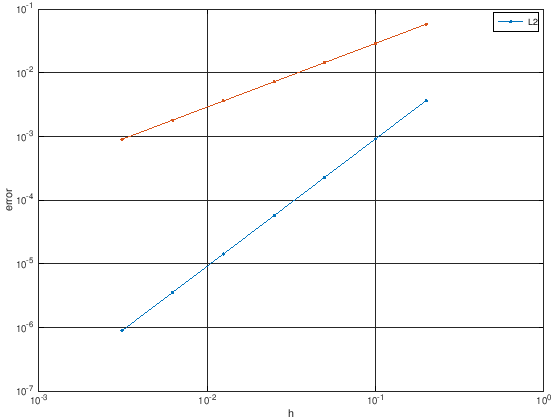

In [15]:
figure;
h_vec = L./N_vec;
plot(h_vec,L2error_vec,'.-');
hold on
plot(h_vec,H1error_vec,'.-');
set(gca,'XScale','log');
set(gca,'YScale','log');
grid on
legend("L2");
xlabel("h");
ylabel("error");